In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk

In [ ]:
target = 'KIC 5184732'
tgt = 'KIC5184732'

tpf = lk.search_targetpixelfile(f'{target}', mission='Kepler', cadence='short')
tpf

In [ ]:
tpf_list = tpf.download_all(quality_bitmask='hard')

In [ ]:
tpf_zero = tpf_list[0]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
tpf_zero.plot(ax=ax, aperture_mask=tpf_zero.pipeline_mask, title='Pipeline Mask', scale='log')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
%matplotlib widget

current_sector = 0
aper_masks = []
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

def show_sector(sector_idx):
    global aper_mask, flux_data, ny, nx

    tpf_file = tpf_list[sector_idx]
    flux_data = tpf_file.flux[0].value
    ny, nx = flux_data.shape
    aper_mask = np.zeros((ny, nx), dtype=bool)
    plot_aperture()

def plot_aperture():
    ax.clear()
    ax.imshow(flux_data, cmap='viridis', origin='lower',
              extent=(0, nx, 0, ny), norm=LogNorm())
    for y in range(ny):
        for x in range(nx):
            if aper_mask[y, x]:
                rect = patches.Rectangle((x, y), 1, 1,
                                         hatch='///', fill=False,
                                         edgecolor='red', linewidth=1.5)
                ax.add_patch(rect)
    ax.set_title(f"Sector {current_sector + 1} of {len(tpf_list)}")
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    plt.draw()

def on_click(event):
    if event.inaxes != ax:
        return
    x, y = int(np.floor(event.xdata)), int(np.floor(event.ydata))
    if 0 <= x < nx and 0 <= y < ny:
        aper_mask[y, x] = not aper_mask[y, x]
        plot_aperture()

def on_key(event):
    global current_sector

    if event.key == 'enter':
        aper_masks.append(aper_mask.copy())
        current_sector += 1
        if current_sector < len(tpf_list):
            show_sector(current_sector)
        else:
            print("All sectors done.")
            plt.close(fig)

fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key)

# Start with first sector
show_sector(current_sector)
plt.show()


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

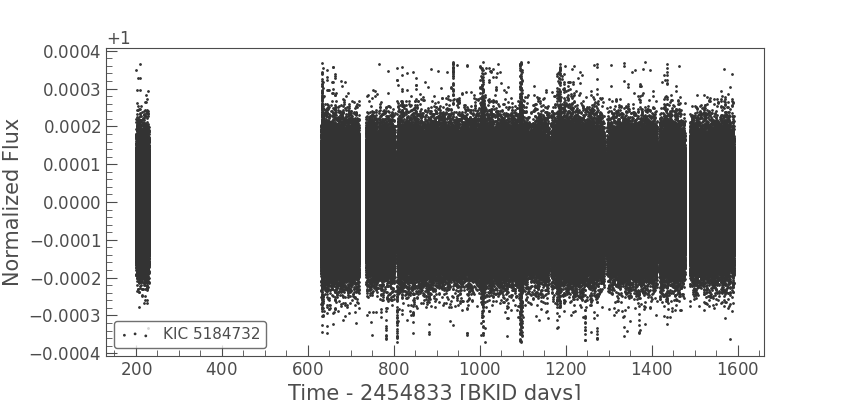

In [11]:
lightcurves = []
for tpf, mask in zip(tpf_list, tpf_list):
    lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
    lightcurves.append(lc)

lc_all = lightcurves[0].append(lightcurves[1:])

lc = lc_all.flatten().remove_outliers(5)
lc.scatter()

<Axes: xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power'>

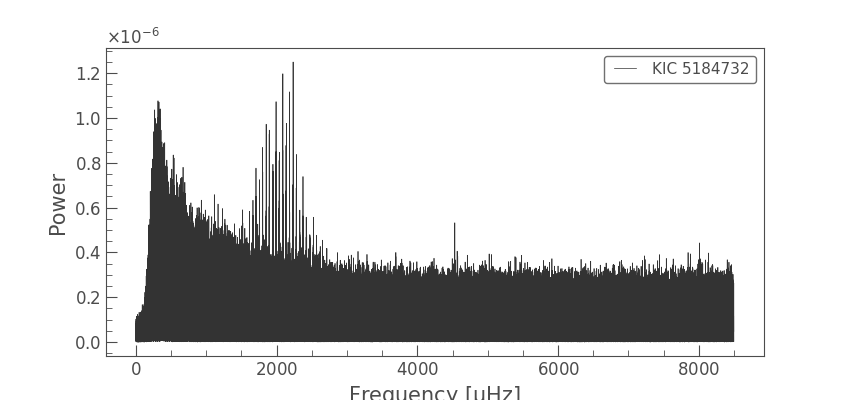

In [12]:
pg = lc.to_periodogram(freq_unit='microhertz')
pg.plot()

In [13]:
time = lc.time.value
flux = (lc.flux.value - 1) * 1e6 # parts-per-million
flux_err = lc.flux_err.value * 1e6 # parts-per-million

np.savetxt('KIC5184732_lc.txt', np.column_stack([time, flux, flux_err]))

<Axes: xlabel='Time [JD]', ylabel='Flux'>

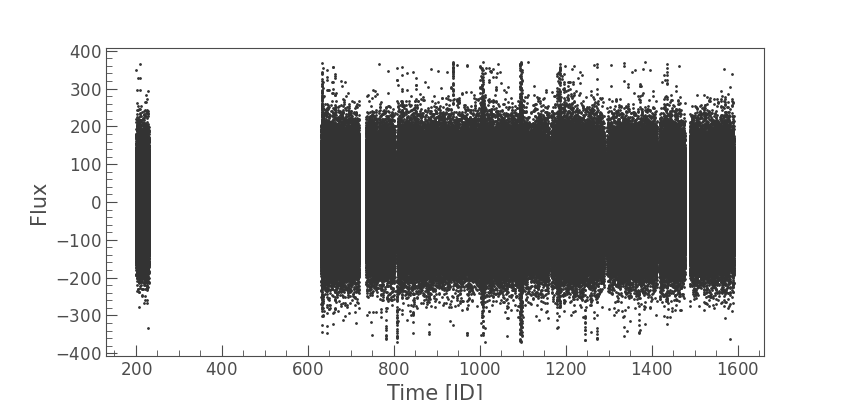

In [14]:
lc = lk.LightCurve(time=time, flux=flux, flux_err=flux_err)
lc.scatter()

<Axes: xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power [$\\mathrm{\\frac{1}{\\mu Hz}}$]'>

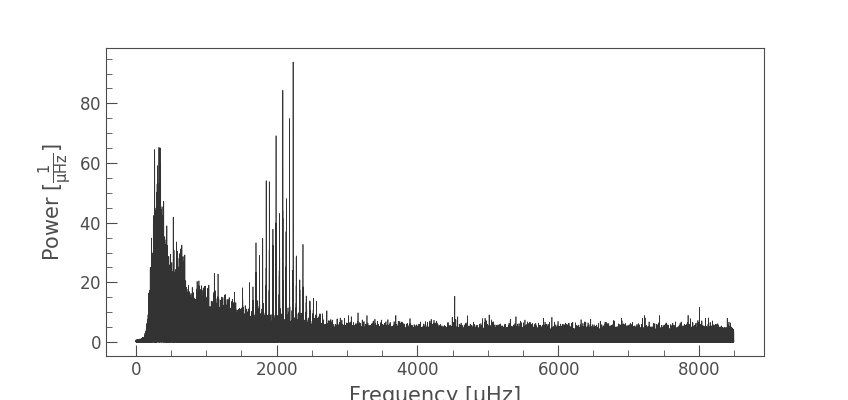

In [15]:
psd = lc.to_periodogram(normalization='psd', freq_unit='microhertz')
np.savetxt('KIC5184732_psd.txt', np.column_stack([psd.frequency.value, psd.power.value]))
psd.plot()

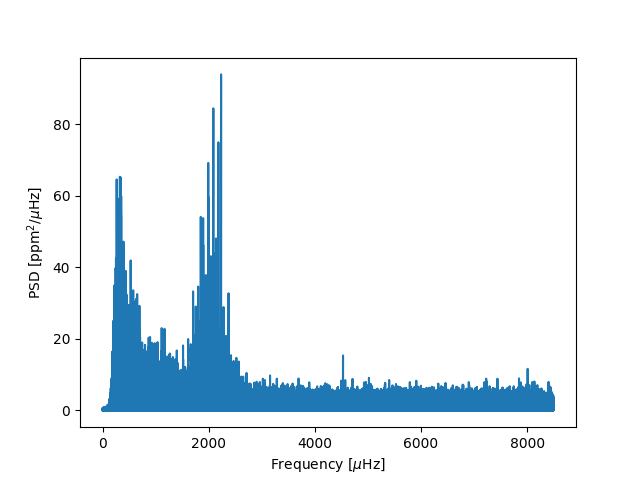

In [17]:
psd = np.genfromtxt('KIC5184732_psd.txt')

f = psd[:,0]
s = psd[:,1]

downsampling = 1

f = f[::downsampling]

s = s[::downsampling]

fig, ax = plt.subplots()
ax.plot(f,s)
ax.set_ylabel('PSD [ppm$^2/\mu$Hz]')
ax.set_xlabel('Frequency [$\mu$Hz]')
plt.show()

In [ ]:
# IN CASE ALL FAILS
'''from pbjam import IO

tgt = 'KIC11017831'

psd = IO.psd(tgt, lk_kwargs={'exptime': 1800, 'mission':'Kepler', 'author':'Kepler'}, use_cached=True)
 
psd()

f = psd.freq

s = psd.powerdensity'''

In [19]:
addObs = {'teff' : (5846, 80), # K
          'bp_rp': (0.9, 0.05),
          'numax': (2089.3, 20.0), # muHz
          'dnu'  : (95.545, 2)} # muHz

In [21]:
from pbjam.modeID import modeID
from pbjam import IO

N_p = 11
 
M = modeID(f, s, addObs, N_p=N_p)

In [22]:
M.runl20model()

23783it [18:06, 21.88it/s, bound: 256 | nc: 32 | ncall: 712133 | eff(%):  3.340 | loglstar:   -inf < -189272.913 <    inf | logz: -189313.404 +/-  0.255 | dlogz: 13.888 >  0.609] 


KeyboardInterrupt: 

In [ ]:
M.spectrum();

In [ ]:
M.result

In [ ]:
# Might not work for RGB stars
M.runl1model(model='RGB');

In [ ]:
M.echelle()

In [ ]:
Nsamples = 10

module = M.l20model #replace this with M.l1model or pb.pbInstances[slice]

fig, ax = plt.subplots()
for k in range(Nsamples):
    
    sample = module.samples[k, :]

    unpacked = module.unpackParams(sample)

    mod = module.model(unpacked)

    ax.plot(module.f, mod, alpha=0.2, color='C3')

In [ ]:
M.result

In [ ]:
from astropy.table import Table

result = M.result

table = Table()
table['l'] = result['ell'].flatten()
table['freq'] = result['summary']['freq'][0]
table['err'] = result['summary']['freq'][1]
table.sort('l')
table
table.write(f'{tgt}.txt', format='ascii.commented_header', overwrite=True)